In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
from ltsfit.lts_linefit import lts_linefit

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
# df = pd.read_csv("edd_cf4_refined.csv", sep='|')
df = pd.read_csv("btfr_brent_updated.csv", sep='|')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df = df.rename(columns={"e_F21":"eF21"})

df = df.set_index("PGC")
print(df.columns)
print(len(df))

df.head()

Index(['flag', 'DM_av', 'eDM', 'DM_riz', 'eDM_riz', 'DM_W1', 'eDM_W1', 'DM_75',
       '1PGC', 'Nest', 'logMs_riz', 'logMs_W1', 'logM_gas', 'logMb', 'Vhel',
       'Vls', 'v3k', 'f', 'lgWmxi', 'elgWi', 'F21', 'eF21', 'inc', 'einc',
       'g***', 'r***', 'i***', 'z***', 'w1***', 'Qs', 'Qw', 'RA', 'DE',
       'GLong', 'GLat', 'SGL', 'SGB', 'Nkt', 'N15', 'SGLg', 'SGBg', 'Vhg',
       'Vlsg', 'V3kg', 'fg'],
      dtype='object')
10153


,flag,DM_av,eDM,DM_riz,eDM_riz,DM_W1,eDM_W1,DM_75,1PGC,Nest,...,SGL,SGB,Nkt,N15,SGLg,SGBg,Vhg,Vlsg,V3kg,fg
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.57,0.45,NaN,NaN,34.57,0.28,34.11,73150,200275.0,...,341.6440,20.7388,0,7,341.4922,20.7395,5194,5486,4916,1.013
4,1,33.49,0.38,33.44,0.19,33.54,0.19,33.72,120,202766.0,...,316.0587,18.4514,0,0,316.0587,18.4514,4458,4706,4109,1.011
12,1,35.05,0.41,NaN,NaN,35.05,0.23,34.61,12,210177.0,...,286.4249,11.3511,0,1,286.4249,11.3510,6532,6669,6179,1.016
16,1,34.70,0.43,34.66,0.26,34.74,0.25,34.30,16,211419.0,...,287.6119,11.7030,0,1,287.6120,11.7030,5709,5851,5354,1.014
55,1,33.71,0.43,33.70,0.26,33.71,0.25,33.89,55,NaN,...,327.0996,19.7763,0,0,327.0996,19.7763,4779,5052,4454,1.012


In [4]:
df['Vmod'] = df.fg*df.Vlsg   # df.f*df.v3k # 
df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.D75)
df['DM_75'] = 5*df.logD75 + 25 
df['Mg_75'] = df['g***'] - df.DM_75
df['Mr_75'] = df['r***'] - df.DM_75
df['Mi_75'] = df['i***'] - df.DM_75
df['Mz_75'] = df['z***'] - df.DM_75
df['M1_75'] = np.asarray([np.float64(x) for x in df['w1***'].values]) - df.DM_75.values

df['gi'] = df['g***'] - df['i***']

/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
df_alfa = pd.read_csv("ALFALFA.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df_alfa = df_alfa.set_index("PGC")
df_alfa = df_alfa[["F", "e_F"]]
df_alfa.head()

,F,e_F
PGC,,
4,1.96,0.07
6,1.13,0.09
10,2.47,0.06
20,2.30,0.11
28,2.49,0.11


In [6]:
df_adhi = pd.read_csv("ADHI.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)
df_adhi = df_adhi.set_index("PGC")
df_adhi = df_adhi[["Flux"]]

df_adhi.head()

,Flux
PGC,
2,4.73
4,1.85
6,NaN
10,2.47
12,3.40


In [7]:
df = df.join(df_alfa, how='left')
df = df.join(df_adhi, how='left')

df = df.rename(columns={"Vls":"V3k"})

df.head()

,flag,DM_av,eDM,DM_riz,eDM_riz,DM_W1,eDM_W1,DM_75,1PGC,Nest,...,logD75,Mg_75,Mr_75,Mi_75,Mz_75,M1_75,gi,F,e_F,Flux
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.57,0.45,NaN,NaN,34.57,0.28,34.349020,73150,200275.0,...,1.869804,NaN,NaN,NaN,NaN,-22.459020,NaN,NaN,NaN,4.73
4,1,33.49,0.38,33.44,0.19,33.54,0.19,34.011709,120,202766.0,...,1.802342,-18.421709,-18.681709,-18.891709,-18.941709,-17.941709,0.47,1.96,0.07,1.85
12,1,35.05,0.41,NaN,NaN,35.05,0.23,34.779466,12,210177.0,...,1.955893,NaN,NaN,NaN,NaN,-21.189466,NaN,NaN,NaN,3.40
16,1,34.70,0.43,34.66,0.26,34.74,0.25,34.491034,16,211419.0,...,1.898207,-20.131034,-20.631034,-20.911034,-21.091034,-20.501034,0.78,NaN,NaN,1.19
55,1,33.71,0.43,33.70,0.26,33.71,0.25,34.167913,55,NaN,...,1.833583,-18.637913,-18.847913,-18.947913,-18.997913,-17.967913,0.31,NaN,NaN,4.30


In [8]:
df['F21_av'] = df[["F", "Flux"]].mean(axis=1)

dg = df[["F21", "eF21", "F", "e_F", "Flux", "F21_av"]]
dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)


adhi_list = [5072, 9670, 49734, 51401, 1737674, 3091777, 5807477]
dg.loc[adhi_list]['F21_'] = dg.loc[adhi_list].Flux   # using ADHI HI flux values


len(dg)

# df["F21"] = dg.F21_
# df["eF21"] = dg.F21_e

<ipython-input-8-69eae98da3b9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
<ipython-input-8-69eae98da3b9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)


10153

In [9]:
new_drop = pd.read_csv("drop_january2021.bar", sep='|')

df = df.drop(new_drop.PGC.values, errors='ignore')

len(df)

10153

In [10]:
calib = pd.read_csv("../calibrators/allzpa_labels.csv", sep=',')

for col in calib.columns:
    newcol = col.strip()
    calib.rename(columns={col:newcol}, inplace=True)
    
calib_weird = [68535, 28378, 42081, 39461, 44536]
calib['Name']=calib.apply(lambda x: None if x.PGC in calib_weird else x.Name, axis=1)
            
calib.set_index('PGC', inplace=True)

calib = calib.join(df[["V3k", "Vmod", "Qs", "Qw", "F21", 'eF21', 'elgWi', 'g***', 'r***', 'i***', 'z***']]).dropna()
calib = calib[(calib.Qs>2) & (calib['i']>0)]

calib['Dist'] = 10**((calib.dm19-25)/5.)
calib['Mass_HI'] = 2.356E5 * calib.F21 * (calib.Dist**2)


for waveband in ['g***','r***','i***','z***']:
    calib[waveband] = calib.apply(lambda x: x[waveband] if x[waveband]!=0 else np.nan, axis=1)
for waveband in ['g','r','i','z']:
    calib[waveband+'***'] = calib.apply(lambda x: x[waveband+'***'] if x[waveband]!=0 else np.nan, axis=1)

calib['Mr'] = calib['r***']-calib.dm19
calib['Mi'] = calib['i***']-calib.dm19
calib['Mz'] = calib['z***']-calib.dm19
calib['gi'] = calib["g***"]-calib['i***']


calib['logMs_i']  = 1.619 + 0.510*calib.gi - 0.4*calib['Mi']
calib['logMs_r']  = 1.617 + 0.650*calib.gi - 0.4*calib['Mr']
calib['logMs_z']  = 1.610 + 0.461*calib.gi - 0.4*calib['Mz']


calib['logMs_riz'] = calib.logMs_r

calib['Ms_riz'] = 10**calib.logMs_riz
calib = calib.dropna()

print(len(calib))
calib.head()

45


,So,Name,dm19,inc,lgWmxi,eWi,Mu,Mg,Mr,Mi,...,i***,z***,Dist,Mass_HI,gi,logMs_i,logMs_r,logMs_z,logMs_riz,Ms_riz
PGC,,,,,,,,,,,,,,,,,,,,,
21396,2,NGC2403,27.514,58,2.454,0.026,-18.56,-19.43,-19.704,-19.854,...,7.66,7.64,3.182731,3.273213e+09,0.42,9.7748,9.7716,9.75322,9.7716,5.910170e+09
28357,2,NGC3021,32.327,58,2.454,0.022,-19.11,-20.11,-20.617,-20.897,...,11.43,11.30,29.201153,2.535331e+09,0.79,10.3807,10.3773,10.38499,10.3773,2.383966e+10
32192,2,NGC3368,30.165,52,2.630,0.024,-19.29,-20.67,-21.355,-21.715,...,8.45,8.31,10.789467,2.248998e+09,1.04,10.8354,10.8350,10.83144,10.8350,6.839116e+10
32207,2,NGC3370,32.149,56,2.514,0.021,-19.43,-20.22,-20.589,-20.779,...,11.37,11.30,26.902956,4.424994e+09,0.56,10.2162,10.2166,10.20776,10.2166,1.646645e+10
34695,2,NGC3627,30.125,64,2.605,0.015,-20.04,-21.16,-21.715,-21.985,...,8.14,7.99,10.592537,1.206747e+09,0.82,10.8312,10.8360,10.84202,10.8360,6.854882e+10


In [11]:
# calib.loc[26317].head(20)

In [12]:
def linear(x, m, b):
    return m*x+b

def linear_m(x, m):
    return m*x

In [13]:
gamma = np.log10(0.5) + 0.4*5.91
df['logMs_W1'] = gamma - 0.4*df['M1_75']
df['Ms_W1'] = 10**df.logMs_W1

df['Mass_HI'] = 2.356E5 * df.F21 * (df.D75**2)

df['logMs_i']  = 1.619 + 0.510*df.gi - 0.4*df['Mi_75']
df['logMs_r']  = 1.617 + 0.650*df.gi - 0.4*df['Mr_75']
df['logMs_z']  = 1.610 + 0.461*df.gi - 0.4*df['Mz_75']

alfa = 0.650
beta = 1.617
df['logMs_riz'] = df.logMs_r
df['Ms_riz'] = 10**df.logMs_riz

In [14]:
mc = -6.158810238893366e-05

def HI_corrector(mc, bc, V3k):
    return 0 # mc*V3k+bc

/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-15-be3d67e5c680>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


iter:  0
iter:  1
3.127397294851756 10.488457178754516


<ipython-input-15-be3d67e5c680>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
<ipython-input-15-be3d67e5c680>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb


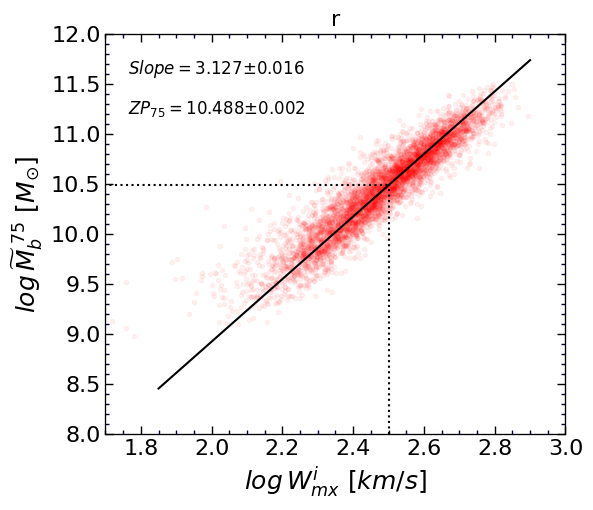

In [15]:
df['Mb'] = df.Ms_riz + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.



for jj in range(2):
    
    dff = dff[np.abs(dff.delta)<3.5*std]

    logW = dff.lgWmxi.values
    logWe = dff.elgWi.values
    logMass = dff.logMb.values
    V3k = dff.V3k.values

    ln10 = np.log(10)
    dMs = 0.4*0.05*ln10
    dM21 = 2.356E5 * dff.eF21.values * (dff.D75.values**2)
    dMb = np.sqrt(dMs**2+(1.33**2)*dM21**2)
    Mb = dff.Ms_riz.values + 1.33*(10**(np.log10(dff.Mass_HI.values)))
    dlogMb = dMb/Mb/ln10


    fit, cov = curve_fit(linear, logMass, logW-2.5, sigma=np.sqrt(logWe**2+(0.01)**2))
    m, b = fit[0], fit[1]
    me = np.sqrt(cov[0,0])
    be = np.sqrt(cov[1,1])
    mbe = cov[1,0]    
    m0 = 1./m
    b0 = -b/m
    dm0 = np.abs(me/m**2)
    db0 = np.sqrt((b0**2 )*(be**2/b**2+me**2/m**2-2*mbe/m/b))
    
    
    fit, cov = np.polyfit(logW-2.5, logMass, 1, w=1./(m*logWe), cov=True)
    m = fit[0]
    b = fit[1]
    
#     if jj>0:
#         mcfit = lts_linefit(logW-2.5, logMass, np.sqrt(logWe**2+(0.01)**2), 0.*dlogMb+0.01, clip=3.)    

    dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
    dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
    std = dff['delta'].std()
    
    print("iter: ", jj)

    
logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

##################################################################

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values
ax.plot(logW, logMass, '.', color='red', alpha=0.05) 


w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + b0, 'k-')
print(m0,b0)    
        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ \widetilde{M}_b^{\/\/75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("r", fontsize=16)

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.95*Xlm[0]+0.05*Xlm[1]
y0 = 0.1*Ylm[0]+0.9*Ylm[1]
ax.text(x0,y0, r"$Slope = $"+"%.3f" % m0+'$\pm$'+"%.3f" % dm0, fontsize=12, color='k')
y0 = 0.2*Ylm[0]+0.8*Ylm[1]
ax.text(x0,y0, r"$ZP_{75} = $"+"%.3f" % b0+'$\pm$'+"%.3f" % db0, fontsize=12, color='k')

ax.plot([2.5,2.5], [8, b0], 'k:')
ax.plot([0,2.5], [b0, b0], 'k:')

3.127397294851756 10.488457178754516


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-16-cad8700388b2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


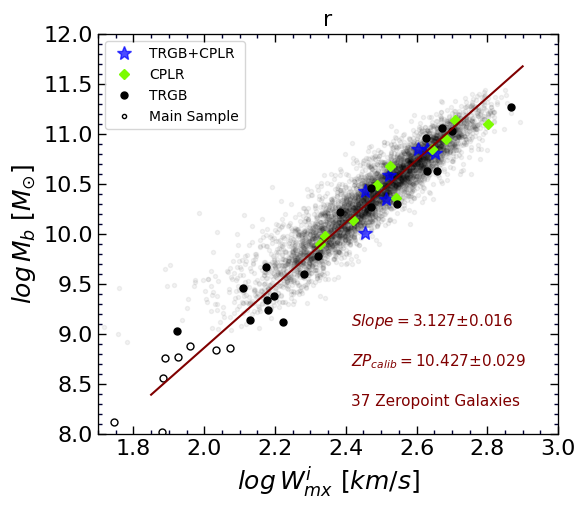

In [16]:
df['Mb'] = df.Ms_riz + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

calib['Mb'] = calib.Ms_riz + 1.33*(10**(np.log10(calib.Mass_HI)+HI_corrector(mc, 0, calib.V3k.values)))
calib['logMb'] = np.log10(calib.Mb.values)


dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.

# m0 = 3.407
# b0 = 10.360
# dm0 = 0.010
# db0 = 0.007
    

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

##################################################################
def linear_zp(x, zp):
    
    return x/m0+zp

X = calib.lgWmxi.values
Xe = calib.elgWi.values
Y = calib.logMb.values
BB = calib['logMb']
So = calib.So.values

fit, cov = curve_fit(linear_zp, Y[BB>9], X[BB>9]-2.5, sigma=np.sqrt(Xe[BB>9]**2+(0.01)**2))
zp_calib = -fit[0]*m0
zp_calib_e = np.sqrt(cov[0][0])*m0

zp_calib_e = np.sqrt(zp_calib_e**2+db0**2)

zp_calib += 0.044


logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values
ax.plot(logW, logMass-b0+zp_calib, '.', color='k', alpha=0.05) 

ind, = np.where((BB<9)&(So==2))
ax.plot(X[ind], Y[ind], '*', ms=10, color='blue', mfc='white') 
ind, = np.where((BB>9)&(So==2))
ax.plot(X[ind], Y[ind], '*', ms=10, color='blue', alpha=0.7, label='TRGB+CPLR') 


ind, = np.where((BB<9)&(So==0))
ax.plot(X[ind], Y[ind], 'D', ms=5, color='lawngreen', mfc='white') 
ind, = np.where((BB>9)&(So==0))
ax.plot(X[ind], Y[ind], 'D', ms=5, color='lawngreen', alpha=1.0, label='CPLR') 


ind, = np.where((BB<9)&(So==1))
ax.plot(X[ind], Y[ind], 'o', ms=5, color='k', mfc='white') 
ind, = np.where((BB>9)&(So==1))
ax.plot(X[ind], Y[ind], 'o', ms=5, color='k', label='TRGB') 

ax.plot([0], [0], '.', color='k', label='Main Sample', mfc='white') 
#######################################################################

w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + zp_calib, '-', color='maroon')
print(m0,b0)    

    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$log \/ \widetilde{M}_b \/\/ [M_{\odot}]$', fontsize=18)
ax.set_ylabel(r'$log \/ M_b \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("r", fontsize=16)

# Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
# x0 = 0.95*Xlm[0]+0.05*Xlm[1]
# y0 = 0.1*Ylm[0]+0.9*Ylm[1]
# ax.text(x0,y0, r"$Slope = $"+"%.3f" % m0+'$\pm$'+"%.3f" % dm0, fontsize=12, color='k')
# y0 = 0.2*Ylm[0]+0.8*Ylm[1]
# ax.text(x0,y0, r"$ZP_{75} = $"+"%.3f" % b0+'$\pm$'+"%.3f" % db0, fontsize=12, color='k')


Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.45*Xlm[0]+0.55*Xlm[1]
y0 = 0.93*Ylm[0]+0.07*Ylm[1]
ax.text(x0,y0, "%d"%len(Xe[BB>9])+' Zeropoint Galaxies', fontsize=11, color='maroon')
y0 = 0.83*Ylm[0]+0.17*Ylm[1]
ax.text(x0,y0, r"$ZP_{calib} = $"+"%.3f" % zp_calib+'$\pm$'+"%.3f" % zp_calib_e, fontsize=11, color='maroon')
y0 = 0.73*Ylm[0]+0.27*Ylm[1]
ax.text(x0,y0, r"$Slope = $"+"%.3f" % m0+'$\pm$'+"%.3f" % dm0, fontsize=11, color='maroon')

ax.legend(loc=2)

In [17]:
np.std(Y[(Y<11.5)&(Y>9.0)] - (m0*(X[(Y<11.5)&(Y>9.0)]-2.5) + zp_calib))

0.18125093588245664

In [18]:
std

10000000000.0

In [19]:
b0 = zp_calib
b0

10.426608795607802

/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-20-85d3970b3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


718
758
53


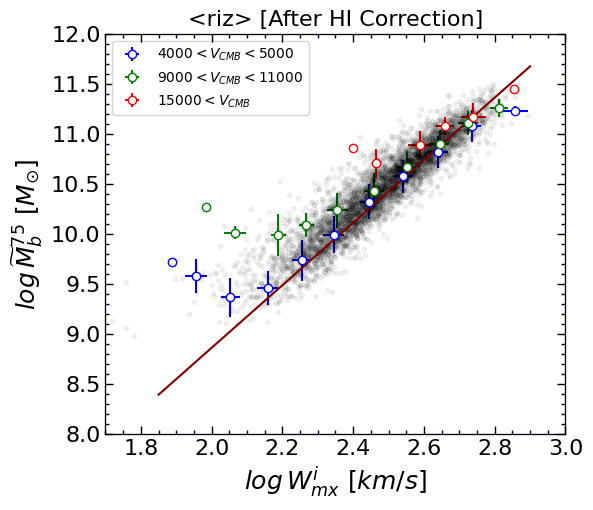

In [20]:
df['Mb'] = df.Ms_riz + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.
    

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(logW, logMass, 'k.', alpha=0.05) 

X0 = logW
Y0 = logMass
V3k = dff.V3k.values
label=r'$4000<V_{CMB}<5000$'
ind, = np.where((V3k>4000)&(V3k<5000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)       
        
        
label=r'$9000<V_{CMB}<11000$'
ind, = np.where((V3k>9000)&(V3k<11000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)      
   

        
label=r'$15000<V_{CMB}$'
ind, = np.where((V3k>15000)&(V3k<20000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)   
    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ \widetilde{M}_b^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("<riz> [After HI Correction]", fontsize=16)

ax.legend()

ax.plot(w, m0*(w-2.5) + b0, '-', color='maroon')

In [21]:
m0, b0, alfa, beta

(3.127397294851756, 10.426608795607802, 0.65, 1.617)

In [22]:
def getDM(mag_r, mag_i, mag_z, Wlog, F21, m0, b0, D, gi, V3k):
    
    Mb = 10**(m0*(Wlog-2.5)+b0)
    
    M21 = 2.356E5 * F21 * (D**2)
    M21 = 10**(np.log10(M21) + HI_corrector(mc, 0, V3k))
        
    alfa = 0.650
    beta = 1.617
    logXriz = beta + alfa*gi
    
    Mag_riz = -2.5*(np.log10(Mb - 1.33*M21) - logXriz)
    
    if mag_r>0 :
        DM = mag_r - Mag_riz
    else:
        return np.nan

    
    D = 10**((DM-25)/5)
    
    return D


def interpol(X, Y):
    
    X0 = X[~np.isnan(Y)]
    Y0 = Y[~np.isnan(Y)]
      
    N = len(X0)
    
    for i in range(N-1):
        
        if Y0[i]<0 and Y0[i+1]>0:
            break

    return -Y0[i]*(X0[i+1]-X0[i])/(Y0[i+1]-Y0[i])+X0[i]

In [23]:
def getDM_simul(D, mag, gi, Wlog, F21, alfa, beta, MtoLscatter, slope, zp, V3k, mc):
    
    Mb = 10**(slope*(Wlog-2.5)+zp)
    
    M21 = 2.356E5 * F21 * (D**2)
    M21 = 10**(np.log10(M21) + mc*V3k)
    
    logX = beta + alfa*gi   
    Mag  = -2.5*(np.log10(Mb - 1.33*M21) - logX)
       
    DM = mag - Mag
    D = 10**((DM-25)/5)
    
    return D

npzName = "MLratio_r_gi.npz"
npzfile = np.load(npzName)
samples_ = npzfile['arr_0']
samples_ = samples_[np.where(samples_[:,0]>0.60)]
samples_ = samples_[(samples_[:,1]>-1)&(samples_[:,1]<1.68)]
samples_ = samples_[np.where(samples_[:,3]>10.25)]

alfaPool = samples_[:,0]
betaPool = samples_[:,1]
slopePool = samples_[:,2]
meanZP = np.mean(samples_[:,3])
zpPool = samples_[:,3]-meanZP+b0

n, m = samples_.shape

Nsimul = 300

In [24]:
t1 =  datetime.now()
print(t1)

dff = df[(df.Qs>0)&(df.elgWi>0)&(df.lgWmxi>0)]
Wlog = dff.lgWmxi.values
eWlog = dff.elgWi.values
F21 = dff.F21.values
eF21 = dff.eF21.values
D75 = dff.D75.values
gi = dff.gi.values
V3k = dff.V3k.values
PGC = dff.index.values
mag_r = dff["r***"].values
mag_i = dff["i***"].values
mag_z = dff["z***"].values


N = len(dff)
DM_fid = np.zeros(N) + np.nan
eDM_fid = np.zeros(N) + np.nan
DMav_fid = np.zeros(N) + np.nan
print(N)
pp=0


for j in range(N): # range(50): #
    
    if mag_r[j]>0 and mag_i[j]>0 and mag_z[j]>0:
        D = np.arange(0.5,800,0.5)

        delta =  D - getDM(mag_r[j], mag_i[j], mag_z[j], Wlog[j], F21[j], m0, b0, D, gi[j], V3k[j])

        D = D[~np.isnan(delta)]
        delta = delta[~np.isnan(delta)]

        try:
            D_root = interpol(D, delta)
            DM_fid[j] = 5*np.log10(D_root)+25
        except:
            D_root = np.max(D[delta<0])
            DM_fid[j] = 5*np.log10(D_root)+25
            print("flag (j, pgc): ", j, PGC[j])
            pp+=1
        if j%1000==0:
            print(j, datetime.now())
    else:
        print("flag (j, pgc, nan): ", j, PGC[j])
        D_root = np.nan
        
    ## uncertainty calucaltion unit
    try:
        DMsimuls = np.zeros(Nsimul) + np.nan
        for i in range(Nsimul):
            try:

                jj = np.random.randint(n)
                D = np.arange(0.5,800,0.5)
                delta = D - getDM_simul(D, \
                                  np.random.normal(mag_r[j], 0.07), \
                                  np.random.normal(gi[j], 0.1), \
                                  np.random.normal(Wlog[j], eWlog[j]), \
                                  np.random.normal(F21[j], eF21[j]), \
                                  alfaPool[jj], betaPool[jj], \
                                  np.random.normal(0, 0.07), \
                                  slopePool[jj], np.random.normal(zpPool[jj], 0.04), \
                                  V3k[j], \
                                  np.random.normal(mc, 7.34669673e-07))
                D = D[~np.isnan(delta)]
                delta = delta[~np.isnan(delta)]
                try:
                    D0 = interpol(D, delta)
                    DMsimuls[i] = 5*np.log10(D0)+25
                except:
                    D0 = np.max(D[delta<0])
                    DMsimuls[i] = 5*np.log10(D0)+25
            except:
                pass    


        eDM_fid[j]  = np.std(DMsimuls)
        DMav_fid[j] = np.mean(DMsimuls)
#         print("pgc, DM, DMav, eDM : ", j, PGC[j], "%.2f"%DM_fid[j], "%.2f"%DMav_fid[j], "%.2f"%eDM_fid[j])
#         print("   ", Wlog[j], eWlog[j], F21[j], eF21[j], V3k[j], gi[j])
        
    except:
        pass
    

        
        

print("Number of concerning distances:", pp)

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

2021-08-11 18:19:24.302865
7096
0 2021-08-11 18:19:24.313247


<ipython-input-22-a4ca0b86cfc6>:12: RuntimeWarning: invalid value encountered in log10
  Mag_riz = -2.5*(np.log10(Mb - 1.33*M21) - logXriz)
<ipython-input-23-a6bbbc78087f>:9: RuntimeWarning: invalid value encountered in log10
  Mag  = -2.5*(np.log10(Mb - 1.33*M21) - logX)
<ipython-input-23-a6bbbc78087f>:6: RuntimeWarning: invalid value encountered in log10
  M21 = 10**(np.log10(M21) + mc*V3k)


1000 2021-08-11 18:22:32.925698
flag (j, pgc, nan):  1317 23362
flag (j, pgc, nan):  1549 26317


<ipython-input-22-a4ca0b86cfc6>:6: RuntimeWarning: divide by zero encountered in log10
  M21 = 10**(np.log10(M21) + HI_corrector(mc, 0, V3k))


flag (j, pgc, nan):  1756 28630
2000 2021-08-11 18:26:01.657196
flag (j, pgc, nan):  2966 42089
3000 2021-08-11 18:29:20.118668
flag (j, pgc, nan):  3702 51664
4000 2021-08-11 18:32:52.242576
flag (j, pgc, nan):  4261 57627
5000 2021-08-11 18:36:42.126817
6000 2021-08-11 18:40:31.268008
7000 2021-08-11 18:43:55.522280
Number of concerning distances: 0
Execution time:
0:24:47.969195


In [25]:
for j in range(N):
    
    if np.abs(DM_fid[j]-DMav_fid[j]) > 0.1:
        print(PGC[j], "%.2f"%DM_fid[j], "%.2f"%DMav_fid[j], "%.2f"%eDM_fid[j])

55 33.53 33.88 0.25
68 34.70 34.88 0.42
70 35.02 35.41 0.19
76 34.59 34.78 0.24
92 32.75 32.97 0.20
96 36.26 36.60 0.21
102 34.17 34.34 0.20
124 34.26 34.61 0.19
128 35.49 36.19 0.27
146 34.13 34.30 0.31
165 34.66 34.95 0.20
176 34.96 35.13 0.30
186 35.00 35.27 0.21
201 35.12 35.24 0.35
205 34.84 35.11 0.29
212 36.12 36.45 0.21
216 33.97 34.17 0.25
218 31.51 31.63 0.19
222 35.02 35.61 0.20
247 36.84 37.19 0.34
250 34.18 34.37 0.28
257 34.82 35.31 0.18
258 35.85 36.16 0.20
259 34.60 34.77 0.27
298 33.56 33.75 0.26
301 34.09 34.24 0.19
303 33.43 33.63 0.30
305 32.81 32.92 0.21
312 33.20 33.32 0.27
329 33.95 34.38 0.26
345 34.09 34.63 0.34
354 34.63 34.81 0.30
366 34.66 34.83 0.35
415 34.96 35.13 0.28
431 34.37 34.72 0.20
451 34.03 34.15 0.21
465 35.76 35.94 0.32
496 30.69 30.41 0.26
507 34.89 35.04 0.22
559 34.11 34.39 0.18
567 35.08 35.26 0.26
569 34.34 34.52 0.21
613 34.62 34.75 0.25
616 35.76 36.04 0.33
619 32.75 32.87 0.28
642 34.45 34.59 0.25
644 33.63 33.80 0.29
650 33.83 33.95 0.2

8131 34.66 34.81 0.24
8165 33.68 33.86 0.26
8171 34.34 34.52 0.18
8173 33.77 33.89 0.20
8175 34.67 34.88 0.21
8188 36.76 37.31 0.21
8220 34.28 34.46 0.25
8235 34.99 35.10 0.38
8245 34.01 34.19 0.23
8255 33.95 34.43 0.23
8266 34.93 35.13 0.21
8281 33.65 33.75 0.23
8293 34.89 35.12 0.27
8318 34.44 34.60 0.28
8360 32.77 32.88 0.29
8379 35.05 35.20 0.23
8400 33.96 34.34 0.22
8417 34.95 35.05 0.25
8420 33.30 33.67 3.13
8450 33.03 33.83 0.27
8452 33.25 33.56 0.17
8518 34.78 35.11 0.26
8527 35.52 35.76 0.34
8531 34.84 34.97 0.30
8556 35.59 35.93 0.40
8571 36.58 36.82 0.30
8581 33.43 33.55 0.26
8599 34.16 34.40 0.17
8609 33.38 33.57 0.24
8624 33.87 34.07 0.16
8635 34.72 34.87 0.22
8642 33.96 34.22 0.17
8662 35.06 35.20 0.42
8676 34.69 34.91 0.26
8685 34.85 35.14 0.19
8686 34.19 34.55 0.42
8691 32.05 31.91 0.28
8729 34.67 35.14 0.29
8762 32.20 32.03 0.51
8766 33.88 34.03 0.22
8778 34.74 35.00 0.25
8821 33.64 33.80 0.25
8822 33.86 34.03 0.31
8838 34.18 34.52 0.18
8852 32.49 32.31 0.48
8882 34.14

26871 34.49 34.71 0.32
26899 31.21 30.85 0.70
26906 36.49 36.84 0.28
26932 32.74 32.87 0.22
26966 33.78 33.93 0.20
26978 35.16 35.35 0.23
26982 35.38 35.67 0.37
26989 35.91 36.34 0.31
26990 36.29 36.58 0.93
27005 35.37 35.58 0.44
27009 34.55 34.69 0.22
27059 33.34 33.53 0.16
27114 36.02 36.32 0.28
27216 33.76 34.05 0.22
27219 34.71 34.92 0.38
27220 34.83 34.99 0.22
27221 35.71 36.63 0.28
27236 36.13 36.47 0.33
27249 33.56 33.69 0.21
27259 34.82 35.05 0.27
27266 35.07 35.29 0.47
27310 33.84 33.95 0.23
27311 31.74 31.43 0.63
27358 34.44 34.59 0.25
27361 33.50 33.61 0.27
27368 33.18 33.46 0.23
27371 35.00 35.30 0.23
27388 35.21 35.41 0.19
27398 34.74 35.04 0.24
27402 36.08 36.36 0.25
27432 34.40 34.61 0.21
27436 33.41 33.53 0.18
27437 34.08 34.20 0.25
27451 32.78 32.88 0.20
27455 36.23 36.54 0.33
27518 34.14 34.27 0.26
27544 34.20 34.39 0.25
27549 34.41 34.64 0.28
27552 34.65 34.89 0.30
27558 34.36 34.52 0.18
27564 35.15 35.42 0.30
27570 34.37 34.56 0.17
27572 34.87 35.08 0.28
27574 34.12

33713 35.05 35.16 0.39
33728 36.29 36.51 0.25
33738 35.89 36.24 0.25
33739 35.93 36.27 0.27
33746 36.27 37.01 0.21
33760 34.47 34.69 0.22
33768 34.65 34.85 0.23
33786 35.12 35.42 0.19
33802 34.73 35.10 0.19
33817 33.73 33.94 0.17
33849 35.40 35.52 0.34
33869 34.84 35.09 0.20
33875 32.30 32.18 0.50
33876 35.38 35.62 0.24
33892 35.97 36.37 0.32
33925 34.49 34.75 0.19
33930 34.51 34.69 0.21
33943 33.26 33.36 0.35
33947 35.82 36.21 0.21
33959 29.60 29.22 0.35
33964 33.04 33.18 0.23
33982 35.06 35.32 0.22
34011 35.44 35.73 0.23
34068 32.38 32.18 0.22
34112 35.34 35.78 0.24
34121 34.21 34.48 0.18
34125 34.96 35.14 0.23
34135 31.46 31.19 0.29
34139 35.24 35.61 0.26
34167 34.92 35.11 0.38
34173 34.33 34.47 0.28
34180 35.22 35.36 0.32
34181 34.64 35.02 0.26
34204 35.28 35.56 0.22
34236 34.91 35.16 0.42
34247 34.54 34.68 0.19
34248 31.53 31.35 0.22
34308 32.33 32.23 0.44
34363 35.09 35.25 0.27
34373 34.51 34.84 0.25
34382 32.36 32.16 0.22
34409 34.88 35.50 0.17
34411 35.85 36.05 0.25
34419 31.53

38684 33.20 33.09 0.58
38688 29.38 29.15 0.30
38709 35.29 35.56 0.20
38713 34.75 34.87 0.21
38755 34.43 34.69 0.24
38765 35.02 35.14 0.47
38785 34.97 35.14 0.24
38803 31.90 31.64 0.29
38834 34.58 34.77 0.31
38848 33.64 33.77 0.22
38851 33.11 33.22 0.28
38864 34.64 34.97 0.24
38874 34.84 35.01 0.22
38897 30.53 30.42 0.16
38898 35.94 36.17 0.37
38919 35.48 35.72 0.23
38933 33.92 34.30 0.20
38945 31.02 30.71 0.22
38958 34.14 34.50 0.58
38961 34.76 35.11 0.19
38977 35.08 35.51 0.17
38984 33.64 33.77 0.20
38989 34.72 35.05 0.47
38998 30.73 30.34 0.26
39009 32.29 32.17 0.59
39028 31.16 31.28 0.20
39038 36.14 36.57 0.27
39046 34.45 34.69 0.21
39051 34.94 35.11 0.21
39052 32.02 31.81 0.48
39099 34.66 34.87 0.19
39101 34.83 35.16 0.19
39113 31.81 31.60 0.22
39143 31.16 30.99 0.23
39177 35.90 36.23 0.23
39181 32.30 32.04 0.27
39191 30.72 30.45 0.42
39206 30.64 30.49 0.22
39230 29.93 29.57 0.38
39232 35.68 36.12 0.23
39237 31.04 30.85 0.41
39245 34.70 34.90 0.25
39246 31.38 31.53 0.20
39256 28.70

45816 34.58 34.74 0.29
45839 33.22 33.34 0.18
45848 31.76 31.65 0.18
45849 30.02 29.87 0.17
45858 31.43 31.23 0.26
45864 33.21 33.39 0.22
45875 30.75 30.49 0.22
45887 34.63 34.89 0.19
45905 34.41 34.63 0.32
45934 33.88 34.03 0.19
45937 34.72 35.01 0.23
45938 34.01 34.18 0.28
45939 28.19 27.45 1.04
45943 35.56 35.70 0.28
45947 34.94 35.16 0.25
45948 31.56 31.69 0.31
45959 34.96 35.20 0.22
45967 34.99 35.30 0.37
46028 34.46 34.60 0.21
46032 34.60 34.70 0.27
46045 34.38 34.51 0.59
46075 34.68 34.88 0.28
46089 34.60 34.84 0.20
46121 35.01 35.35 0.18
46124 35.03 35.30 0.19
46127 28.07 27.57 0.47
46145 33.75 33.92 0.22
46153 29.44 29.54 0.24
46159 31.08 30.88 0.18
46164 34.76 35.17 0.17
46171 34.65 34.92 0.19
46180 34.32 34.56 0.25
46189 35.12 35.34 0.24
46249 35.06 35.46 0.20
46262 34.67 35.15 0.29
46293 33.93 34.06 0.27
46302 34.40 34.59 0.21
46321 34.59 34.85 0.24
46388 35.51 35.87 0.25
46427 35.08 35.39 0.20
46449 34.03 34.23 0.33
46534 36.28 36.63 0.21
46556 30.44 30.14 0.29
46563 31.43

51600 33.88 34.03 0.25
51601 36.00 36.29 0.21
51603 33.69 33.85 0.38
51604 31.16 30.86 0.28
51620 32.90 33.01 0.29
51633 34.70 35.03 0.20
51638 34.66 35.05 0.20
51657 35.31 35.51 0.26
51665 33.59 33.78 0.18
51670 34.10 34.30 0.24
51683 35.08 35.28 0.29
51706 35.05 35.34 0.21
51717 34.16 34.26 0.40
51719 32.86 32.75 0.20
51732 35.49 35.70 0.28
51739 35.78 36.04 0.29
51741 31.87 31.64 0.24
51745 34.09 34.21 0.17
51750 34.18 34.35 0.26
51752 35.56 35.85 0.36
51758 34.45 34.65 0.25
51777 34.87 35.05 0.31
51784 35.33 35.67 0.22
51790 35.35 35.48 0.25
51793 34.41 34.62 0.18
51809 31.28 31.10 0.21
51831 33.81 33.97 0.28
51850 33.62 33.75 0.22
51854 36.09 36.43 0.24
51865 34.90 35.26 0.29
51878 34.87 35.15 0.21
51883 34.79 34.94 0.27
51900 34.67 34.93 0.35
51921 32.71 32.85 0.17
51932 32.56 32.71 0.26
51939 35.67 35.97 0.29
51955 33.05 33.16 0.20
51958 34.19 34.65 0.27
51978 32.72 32.89 0.24
51997 34.38 34.68 0.17
52005 34.34 34.48 0.25
52006 33.73 33.96 0.26
52012 33.90 34.18 0.21
52044 35.91

57037 35.79 36.08 0.26
57042 35.80 36.04 0.27
57061 35.56 36.14 0.18
57083 35.96 36.36 0.20
57091 35.73 36.12 0.26
57110 33.56 33.81 0.23
57122 35.81 35.96 0.30
57178 35.13 35.49 0.23
57181 33.74 33.88 0.16
57193 35.66 35.79 0.30
57216 34.44 34.57 0.32
57218 34.60 34.86 0.36
57246 34.28 34.41 0.24
57250 35.50 35.67 0.28
57251 36.22 36.63 0.22
57273 35.89 36.10 0.30
57274 35.86 36.14 0.28
57278 35.68 35.91 0.26
57280 35.31 35.55 0.29
57284 35.72 36.03 0.23
57287 35.33 35.74 0.27
57293 35.40 35.65 0.27
57329 37.07 37.41 0.26
57337 35.30 35.76 0.24
57340 36.13 36.42 0.23
57349 35.71 36.01 0.24
57353 33.97 34.13 0.25
57356 33.41 33.64 0.17
57365 35.79 36.04 0.24
57369 35.50 35.76 0.21
57370 35.88 36.38 0.25
57373 34.57 34.74 0.23
57377 35.51 35.71 0.27
57390 35.06 35.39 0.23
57396 34.79 34.93 0.40
57407 33.59 33.73 0.23
57417 35.61 35.83 0.28
57430 35.07 35.27 0.25
57445 36.00 36.39 0.51
57463 34.89 35.39 0.23
57478 33.83 34.05 0.36
57498 35.69 36.01 0.25
57499 34.85 35.23 0.21
57505 35.20

69433 34.91 35.06 0.31
69450 34.64 34.75 0.25
69452 34.52 34.65 0.52
69456 35.05 35.28 0.19
69460 34.69 34.97 0.20
69463 34.65 35.01 0.24
69469 34.09 34.40 0.17
69473 35.51 35.80 0.20
69502 35.26 35.40 0.28
69529 35.60 35.92 0.28
69530 35.55 35.77 0.25
69531 33.89 34.00 0.35
69544 34.85 35.13 0.27
69553 34.91 35.15 0.31
69559 36.17 36.55 0.28
69588 37.06 37.50 0.23
69594 36.10 36.42 0.26
69597 34.91 35.10 0.21
69608 34.94 35.18 0.24
69612 35.79 35.99 0.34
69616 34.34 34.77 0.28
69699 35.31 35.52 0.36
69705 33.75 33.86 0.21
69718 34.90 35.05 0.25
69731 35.50 35.92 0.36
69739 35.14 35.40 0.20
69765 34.59 35.02 0.29
69770 34.89 35.23 0.27
69771 35.34 35.58 0.24
69774 34.81 35.07 0.23
69787 35.75 36.00 0.21
69794 36.08 36.37 0.28
69803 35.29 35.49 0.32
69804 34.89 35.20 0.43
69851 35.06 35.20 0.31
69854 35.59 35.87 0.24
69863 35.42 35.81 0.22
69866 34.63 34.77 0.25
69874 32.74 32.85 0.25
69892 35.65 35.90 0.30
69908 35.71 36.18 0.27
69922 34.77 35.08 0.23
69947 31.51 31.34 0.56
69965 35.20

91789 35.03 35.39 0.19
91792 36.62 37.10 0.20
91798 35.77 36.08 0.29
91799 35.39 35.55 0.28
91802 35.38 35.73 0.20
91812 35.44 35.71 0.30
91814 34.24 34.39 0.21
91817 34.99 35.26 0.18
91819 34.58 34.85 0.28
91820 34.78 34.95 0.35
91822 35.47 35.83 0.19
91823 34.88 35.48 0.38
91824 34.49 34.90 0.17
91826 34.46 34.76 0.20
91831 34.41 34.68 0.18
91836 33.94 34.20 0.19
91839 35.25 35.39 0.29
92838 34.60 35.03 0.17
92849 35.74 36.02 0.29
92852 33.58 33.71 0.17
92856 34.57 34.76 0.31
92865 34.25 34.96 0.21
92888 35.16 35.88 0.16
92894 35.11 35.84 0.37
92896 35.12 35.68 0.39
92903 34.85 35.16 0.87
92905 34.73 34.94 0.41
92910 31.92 31.62 0.43
92918 33.99 34.21 0.17
92931 36.06 36.28 0.25
92945 34.19 34.65 0.20
92957 35.05 35.27 0.19
92980 34.21 34.67 0.17
92988 35.27 35.66 0.23
93019 32.96 33.22 0.41
93021 34.60 35.07 0.44
93025 34.66 34.94 0.35
93029 35.26 35.49 0.29
93030 34.02 34.25 0.17
93038 35.77 36.79 0.32
93043 35.77 36.39 0.36
93069 35.13 35.83 0.40
93071 34.14 34.46 0.27
93612 34.82

1370630 36.26 36.62 0.22
1370908 35.17 35.49 0.20
1372255 34.05 34.30 0.17
1372553 34.58 35.04 0.19
1372854 34.06 34.56 0.16
1373119 34.79 34.96 0.32
1373441 35.94 36.97 0.20
1373837 34.50 35.04 0.17
1374536 34.61 35.06 0.20
1374673 32.82 32.64 0.79
1375025 34.54 34.94 0.44
1375281 35.09 35.55 0.20
1375876 35.06 35.93 0.19
1376799 36.14 36.37 0.26
1378162 34.87 35.49 0.46
1378322 35.08 35.65 0.25
1378565 36.14 36.58 0.19
1378672 34.62 34.79 0.35
1380244 35.48 35.93 0.29
1381516 34.86 35.13 0.42
1381614 35.80 36.43 0.23
1382204 32.88 32.69 0.79
1382288 35.17 35.64 0.18
1382398 35.91 36.73 0.18
1385096 34.67 34.78 0.20
1385563 35.24 35.59 0.37
1386236 35.97 36.58 0.21
1386969 35.04 35.42 0.35
1388010 35.69 36.21 0.25
1390585 35.80 36.47 0.27
1391345 33.88 34.23 0.17
1391373 33.19 33.32 0.31
1392304 35.59 36.26 0.16
1393848 35.23 35.52 0.19
1394635 34.00 34.44 0.57
1394706 34.73 35.22 0.32
1394711 36.21 36.69 0.24
1395663 34.84 35.47 0.18
1396570 34.95 35.37 0.19
1396787 34.73 34.89 0.24


1800124 29.94 29.49 1.42
1800162 35.50 35.84 0.24
1801205 35.72 36.22 0.40
1801805 35.46 35.62 0.33
1801925 35.74 36.02 0.20
1802210 33.56 33.70 0.19
1804303 34.89 35.15 0.39
1805856 30.75 30.34 0.37
1806071 35.12 35.42 0.21
1806748 36.57 36.99 0.29
1809186 34.94 35.19 0.23
1809668 35.69 36.66 0.30
1810033 34.11 34.39 0.27
1810208 34.59 35.06 0.51
1811357 34.28 34.53 0.16
1813242 32.12 31.91 0.94
1814509 35.93 36.59 0.27
1815965 35.33 35.98 0.21
1819065 34.19 34.69 0.20
1819988 34.97 35.30 0.23
1821272 34.94 35.16 0.42
1823041 35.24 35.55 0.21
1823684 35.07 35.40 0.32
1825294 34.76 34.97 0.21
1826770 35.41 35.74 0.41
1829631 34.65 35.13 0.20
1830772 34.24 34.40 0.23
1831130 34.70 34.82 0.42
1831385 34.41 34.58 0.22
1832164 32.49 32.20 0.24
1832344 34.87 35.13 0.46
1833846 35.59 35.82 0.35
1834191 34.61 34.90 0.20
1834439 36.50 37.00 0.31
1834820 34.36 34.54 0.20
1835223 35.08 35.36 0.35
1835916 35.66 36.06 0.23
1836659 35.72 36.15 0.22
1836905 34.69 34.99 0.26
1836988 34.79 35.12 0.19


4550282 30.79 30.38 0.43
4550909 35.36 36.05 0.26
4552658 34.62 34.85 0.18
4555565 34.32 34.60 0.53
4563662 32.22 31.92 0.25
4567836 34.17 34.57 0.17
4572357 33.83 34.25 0.17
4572526 33.01 33.35 0.23
4572813 33.53 33.90 0.20
4573085 33.40 33.50 0.21
4573902 34.29 35.19 0.38
4577032 32.88 33.27 0.22
4577792 32.79 32.58 0.20
4609999 30.35 30.06 0.30
4668290 28.21 27.64 0.74
4720579 34.52 34.76 0.29
4780957 34.18 34.67 0.19
5056910 34.00 34.52 0.18
5057047 34.85 35.60 0.38
5057062 31.68 31.42 0.34
5057078 34.11 34.97 0.32
5057082 28.47 27.86 0.72
5057112 34.43 35.28 0.16
5057273 32.87 33.06 0.32
5057334 34.21 34.39 0.17
5057338 33.46 33.77 0.70
5057339 35.41 35.80 0.23
5057344 35.02 35.98 0.31
5057374 33.08 33.19 0.61
5057376 33.39 33.57 0.28
5057381 33.38 33.60 0.83
5057394 33.95 34.35 0.28
5057397 33.96 34.26 0.31
5057405 35.35 36.09 0.37
5057412 33.93 34.32 0.30
5057489 34.75 35.12 0.19
5057497 35.02 35.64 0.16
5057498 35.15 36.12 0.24
5057535 32.34 32.22 0.42
5057536 35.50 36.15 0.24


sig_int:     0.0000         inf
Computing sig_int
sig_int:     0.0000         inf
sig_int: 14767166973624299520.0000     -1.0000
sig_int: 14759783390137487360.0000     -1.0000
sig_int: 7379891695068743680.0000     -1.0000
sig_int: 3689945847534371840.0000     -1.0000
sig_int: 1844972923767185920.0000     -1.0000
sig_int: 922486461883592960.0000     -1.0000
sig_int: 461243230941796480.0000     -1.0000
sig_int: 230621615470898240.0000     -1.0000
sig_int: 115310807735449120.0000     -1.0000
sig_int: 57655403867724560.0000     -1.0000
sig_int: 28827701933862280.0000     -1.0000
sig_int: 14413850966931140.0000     -1.0000
sig_int: 7206925483465570.0000     -1.0000
sig_int: 3603462741732785.0000     -1.0000
sig_int: 1801731370866392.5000     -1.0000
sig_int: 900865685433196.2500     -1.0000
sig_int: 450432842716598.1250     -1.0000
sig_int: 225216421358299.0625     -1.0000
sig_int: 112608210679149.5312     -1.0000
sig_int: 56304105339574.7656     -1.0000
sig_int: 28152052669787.3828     -1.

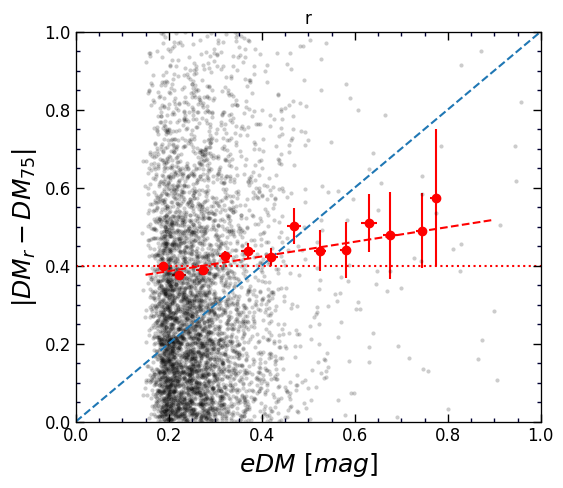

In [26]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = eDM_fid
Y = np.abs(DMav_fid - dff.DM_75.values)

V3k = dff.V3k.values
X = X[V3k>4000]
Y = Y[V3k>4000]

ax.plot(X, Y, 'k.', alpha=0.2, mfc='k', mec='none')

X = X[Y<1]
Y = Y[Y<1]

factor = np.sqrt(np.pi/2.)
for i in np.arange(0.15,0.8,0.05):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.05:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        yp *= factor
        ax.errorbar(np.median(xp), np.mean(yp), yerr=np.std(yp)/np.sqrt(len(yp)), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)  
        
ax.set_ylabel(r'$|DM_{r} - DM_{75}|$', fontsize=18)
ax.set_xlabel(r'$eDM \/\/ [mag]$', fontsize=18)

# ax.plot([0,1], [0,0], ':', color='k')

set_axes(ax, (0,1), (0,1), fontsize=12)

ax.set_title("r")

from ltsfit.lts_linefit import lts_linefit
mcfit = lts_linefit(X, factor*Y, X*0+0.001, Y*0+0.001, clip=3., plot=False)
xx = np.linspace(0.15,0.9,100)
ax.plot(xx, mcfit.ab[1]*xx+mcfit.ab[0], '--', color='red')

yy0 = np.mean(factor*Y)
ax.plot([0,1],[yy0,yy0], ':', color='red')
ax.plot([0,1],[0,1], '--', color='#1f77b4')

<ipython-input-27-c9ba0bd7bb5b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['dDM'] = DM_fid - dff.DM_75.values
<ipython-input-27-c9ba0bd7bb5b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['DMriz_fid'] = DM_fid
<ipython-input-27-c9ba0bd7bb5b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

Text(0.5, 1.0, '<riz>')

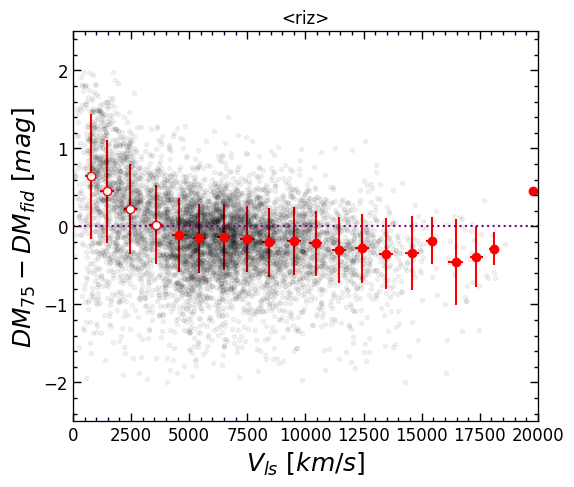

In [27]:
dff['dDM'] = DM_fid - dff.DM_75.values
dff['DMriz_fid'] = DM_fid
dff['DMav_r'] = DMav_fid
dff['eDM_r'] = eDM_fid
eDM_adj = mcfit.ab[1]*eDM_fid+mcfit.ab[0]
for jj in range(len(eDM_fid)):
    if eDM_fid[jj]>eDM_adj[jj]:
        eDM_adj[jj]=eDM_fid[jj]
dff['eDM_r_adj'] = eDM_adj

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.V3k.values
Y = dff.dDM.values
# logW = dff.lgWmxi.values

X = X[np.abs(Y)<2]
Y = Y[np.abs(Y)<2]

ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(4000,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   


for i in np.arange(0,4000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6, mfc='white')   
        
        
ax.set_xlabel(r'$V_{ls} \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$DM_{75} - DM_{fid}\/\/[mag]$', fontsize=18)
# ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-2.5,2.5), fontsize=12)

ax.set_title("<riz>")

In [28]:
np.mean(Y[X>4000])

-0.21564896476467765

Text(0.5, 1.0, 'r')

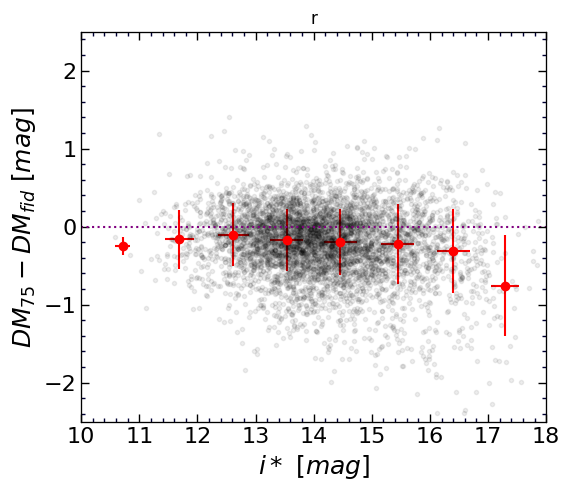

In [29]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


dff_ = dff[dff.V3k>4000]

X = dff_['i***'].values
Y = dff_.dDM.values
V = dff_.V3k.values

ax.plot(X, Y, 'k.', alpha=0.07)

X = X[np.abs(Y)<2]
Y = Y[np.abs(Y)<2]

for i in np.arange(10,18,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$i* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$DM_{75} - DM_{fid}\/\/[mag]$', fontsize=18)
# ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)


ax.plot([10,18], [0,0], ':', color='purple')

set_axes(ax, (10,18), (-2.5,2.5))

ax.set_title("r")

In [30]:
dff['Mass_HI'] = 2.356E5 * dff.F21 * (dff.D75**2)   # D75
try:
    dff['Mb'] = dff.Ms_riz + 1.33*(10**(np.log10(dff.Mass_HI)))
except:
    dff['Mb'] = dff.Ms_r + 1.33*(10**(np.log10(dff.Mass_HI)))
    
dff['logMb'] = np.log10(dff.Mb.values)

dff = dff.rename(columns={'DMriz_fid':'DMr_fid'})
try:
    dff = dff.rename(columns={'Ms_riz':'Ms_r'})
except:
    pass

dff[['DM_75', 'DMr_fid', 'Mass_HI', 'Ms_r', 'Mb', 'F21', 'eF21', 'Qs', 'DMav_r', 'eDM_r', 'eDM_r_adj']].to_csv("MLratio_r_distances_noCorrection.csv")

<ipython-input-30-a63306ad7228>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Mass_HI'] = 2.356E5 * dff.F21 * (dff.D75**2)   # D75
/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-30-a63306ad7228>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Mb'] = dff.Ms_riz + 1.33*(10**(np.log10(dff.Mass_HI)))
<ipython-input-30-a63306ad7228>:7: SettingWithCopy

(3.127397294851756, 10.426608795607802)

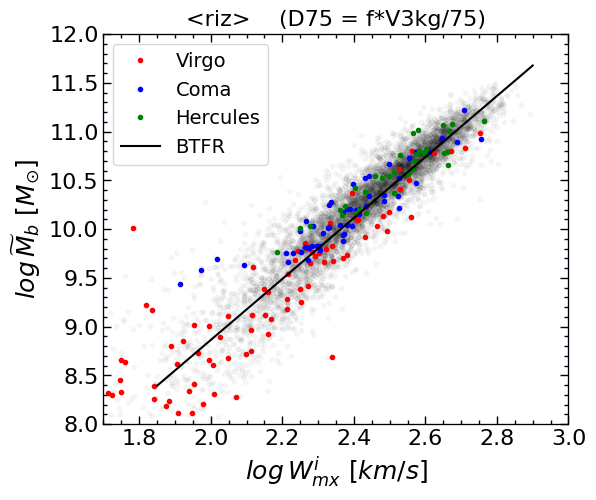

In [31]:
dff['Mass_HI'] = 2.356E5 * dff.F21 * (dff.D75**2)   # D75
dff['Mb'] = dff.Ms_r + 1.33*(10**(np.log10(dff.Mass_HI)+HI_corrector(mc, 0, dff.V3k.values)))
dff['logMb'] = np.log10(dff.Mb.values)

######################################################################
dff = dff.rename(columns={"1PGC": "PGC1"})


df_vrigo = dff[dff.PGC1==41220]
df_coma = dff[dff.PGC1==44715]
df_herc = dff[dff.PGC1==56962]

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

plt.plot(logW, logMass, '.', color='black', alpha=0.03) 


ax.plot(df_vrigo.lgWmxi, df_vrigo.logMb, 'r.', label='Virgo')
ax.plot(df_coma.lgWmxi, df_coma.logMb, 'b.', label='Coma')
ax.plot(df_herc.lgWmxi, df_herc.logMb, 'g.', label='Hercules')

ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ \widetilde{M}_b \/\/ [M_{\odot}]$', fontsize=18)

set_axes(ax, (1.7,3), (8,12))
ax.set_title("<riz>    (D75 = f*V3kg/75)", fontsize=16)

w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + zp_calib, 'k-', label='BTFR')

ax.legend(fontsize=14, loc=2)   

m0, b0

In [32]:
len(dff)

7096